
# Exploratory Data Analysis (EDA)
## Long-Term Climate Analysis: Madrid (ERA5)

Celem niniejszej analizy jest eksploracyjna ocena
długoterminowych zmian klimatu w regionie Madrytu
na podstawie danych reanalizy ERA5 (1994–2024).

Analiza ma charakter deskryptywny i diagnostyczny
i stanowi podstawę do dalszych wniosków
oraz potencjalnego modelowania predykcyjnego.


## 1. Wczytanie danych i wstępna kontrola jakości

### 📌 Kod



In [2]:
# import geopandas as gpd
# import contextily as ctx
# from shapely.geometry import Point
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


files = Path("../clean_data").glob("*.parquet")

df = pd.concat(
    (pd.read_parquet(f) for f in files),
    ignore_index=True
)

df.head(5)



,latitude,longitude,t2m_mean,t2m_max,t2m_min,d2m_mean,skt_mean,sp_mean,blh_mean,tcc_mean,soil_moisture,tp_sum,e_sum,ssrd_sum,date,hour,year,month,day,dayofyear,season,lai_total,ws_mean
0,38.5,-6.0,10.289764,11.458893,9.736481,9.086151,10.105072,97126.875000,434.331635,0.994072,0.293809,0.046730,-0.010526,134144.0,1994-01-01,0,1994,1,1,1,1,3.939392,2.813566
1,38.5,-6.0,11.305145,13.904694,8.105377,7.514069,11.303131,97150.828125,462.986633,0.601974,0.291006,0.000477,-0.171009,2261120.0,1994-01-01,12,1994,1,1,1,1,3.940826,2.670740
2,38.5,-6.0,7.491089,8.396759,6.777008,6.499939,6.366913,97018.609375,52.482376,0.839874,0.290871,0.006199,0.005607,210752.0,1994-01-02,0,1994,1,2,2,1,3.942078,1.328706
3,38.5,-6.0,11.852875,13.744049,9.142242,8.012268,11.847626,96761.234375,453.875336,0.960083,0.288873,0.005722,-0.164966,1872832.0,1994-01-02,12,1994,1,2,2,1,3.943573,1.811240
4,38.5,-6.0,9.341919,10.152496,8.252472,7.491516,8.068237,96438.406250,140.091217,0.609650,0.288914,0.008583,0.004828,222784.0,1994-01-03,0,1994,1,3,3,1,3.944946,2.070344


# Zobaczenie struktury plików

In [5]:
df['date'] = pd.to_datetime(df['date'])
df.info()
df.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7538497 entries, 0 to 7538496
Data columns (total 23 columns):
 #   Column         Dtype         
---  ------         -----         
 0   latitude       float64       
 1   longitude      float64       
 2   t2m_mean       float32       
 3   t2m_max        float32       
 4   t2m_min        float32       
 5   d2m_mean       float32       
 6   skt_mean       float32       
 7   sp_mean        float32       
 8   blh_mean       float32       
 9   tcc_mean       float32       
 10  soil_moisture  float32       
 11  tp_sum         float32       
 12  e_sum          float32       
 13  ssrd_sum       float32       
 14  date           datetime64[ns]
 15  hour           int8          
 16  year           int16         
 17  month          int8          
 18  day            int8          
 19  dayofyear      int16         
 20  season         int8          
 21  lai_total      float32       
 22  ws_mean        float32       
dtypes: date

,count,mean,min,25%,50%,75%,max,std
latitude,7538497.0,40.5,38.5,39.5,40.5,41.5,42.5,1.224745
longitude,7538497.0,-3.75,-6.0,-5.0,-3.75,-2.5,-1.5,1.369306
t2m_mean,7538497.0,13.757123,-17.732483,7.492889,12.795013,19.521057,41.289459,8.309739
t2m_max,7538497.0,16.290411,-16.178314,9.436188,15.424957,22.884918,44.527496,8.857915
t2m_min,7538497.0,11.121436,-20.177246,5.49527,10.417389,16.333649,37.580719,7.503702
d2m_mean,7538497.0,5.736118,-28.781403,2.454376,6.098358,9.370209,21.853363,4.999473
skt_mean,7538497.0,14.021599,-21.581009,6.734955,12.679352,20.429718,45.886627,9.521824
sp_mean,7538497.0,92309.265625,82473.890625,90607.0,92413.078125,93906.625,100307.53125,2556.116211
blh_mean,7538497.0,664.398865,9.965368,241.038483,511.600067,981.85376,3793.989014,531.759705
tcc_mean,7538497.0,0.467761,0.0,0.108849,0.46347,0.79834,1.0,0.352125


In [6]:
print(df.isna().sum())
print(df.columns )

latitude         0
longitude        0
t2m_mean         0
t2m_max          0
t2m_min          0
d2m_mean         0
skt_mean         0
sp_mean          0
blh_mean         0
tcc_mean         0
soil_moisture    0
tp_sum           0
e_sum            0
ssrd_sum         0
date             0
hour             0
year             0
month            0
day              0
dayofyear        0
season           0
lai_total        0
ws_mean          0
dtype: int64
Index(['latitude', 'longitude', 't2m_mean', 't2m_max', 't2m_min', 'd2m_mean',
       'skt_mean', 'sp_mean', 'blh_mean', 'tcc_mean', 'soil_moisture',
       'tp_sum', 'e_sum', 'ssrd_sum', 'date', 'hour', 'year', 'month', 'day',
       'dayofyear', 'season', 'lai_total', 'ws_mean'],
      dtype='object')


Brak wartości brakujących

In [7]:
print(df['date'].min(), df['date'].max())
print(df['latitude'].nunique(), df['longitude'].nunique())



1994-01-01 00:00:00 2025-12-13 00:00:00
17 19


In [8]:
df_regional = df.groupby(['date', 'hour']).mean().reset_index()
df_regional.head(5)



,date,hour,latitude,longitude,t2m_mean,t2m_max,t2m_min,d2m_mean,skt_mean,sp_mean,blh_mean,tcc_mean,soil_moisture,tp_sum,e_sum,ssrd_sum,year,month,day,dayofyear,season,lai_total,ws_mean
0,1994-01-01,0,40.5,-3.75,6.917516,8.434917,5.855246,4.537438,6.146647,93050.531250,622.247314,0.881170,0.330242,0.087998,-0.024541,2.209244e+05,1994.0,1.0,1.0,1.0,1.0,3.800033,3.975323
1,1994-01-01,12,40.5,-3.75,8.791592,10.451378,6.750894,3.223129,7.795242,93100.890625,563.681519,0.766518,0.325172,0.002257,-0.219849,2.312186e+06,1994.0,1.0,1.0,1.0,1.0,3.800113,3.592687
2,1994-01-02,0,40.5,-3.75,6.711174,7.475526,5.975026,5.106534,4.601186,92959.625000,372.973175,0.903820,0.323671,0.034109,-0.003579,1.668603e+05,1994.0,1.0,2.0,2.0,1.0,3.800192,3.318004
3,1994-01-02,12,40.5,-3.75,9.550437,10.244783,8.782334,7.009473,8.778630,92756.609375,603.028992,0.955278,0.322595,0.058345,-0.119060,1.279334e+06,1994.0,1.0,2.0,2.0,1.0,3.800274,3.946280
4,1994-01-03,0,40.5,-3.75,8.260456,8.831530,7.626553,6.556828,6.551033,92406.968750,532.666687,0.783960,0.323396,0.134687,-0.015076,1.512974e+05,1994.0,1.0,3.0,3.0,1.0,3.800352,3.907698


# Sprawdzenie rozkładów, korelacji i wymiarów danych

In [5]:
col_num = [
    't2m_mean', 't2m_max', 't2m_min', 'd2m_mean', 'skt_mean', 'sp_mean', 'blh_mean', 'tcc_mean', 'soil_moisture',
    'tp_sum', 'e_sum', 'ssrd_sum', 'lai_total','ws_mean'
]
print(df[col_num].isna().sum())



t2m_mean         0
t2m_max          0
t2m_min          0
d2m_mean         0
skt_mean         0
sp_mean          0
blh_mean         0
tcc_mean         0
soil_moisture    0
tp_sum           0
e_sum            0
ssrd_sum         0
lai_total        0
ws_mean          0
dtype: int64


In [11]:
print(df[col_num].skew() )

t2m_mean         0.362935
t2m_max          0.261101
t2m_min          0.320005
d2m_mean        -0.391980
skt_mean         0.473641
sp_mean         -0.101927
blh_mean         1.029082
tcc_mean         0.071853
soil_moisture    0.040972
tp_sum           5.913989
e_sum           -1.616651
ssrd_sum         0.789885
lai_total        0.166552
ws_mean          0.972618
dtype: float32


### **Interpretacja skośności (Skewness) dla analizowanych cech**

Skośność mówi nam o asymetrii rozkładu danych względem średniej.

#### **Klucz interpretacyjny:**
*   **Wynik blisko 0:** Rozkład symetryczny (zbliżony do normalnego).
*   **Wynik dodatni (> 0):** Skośność prawostronna (prawy ogon jest dłuższy). Większość wartości jest poniżej średniej, ale występują nieliczne wartości bardzo wysokie.
*   **Wynik ujemny (< 0):** Skośność lewostronna (lewy ogon jest dłuższy). Większość wartości jest powyżej średniej, ale występują nieliczne wartości bardzo niskie.

---

#### **Analiza Twoich wyników:**

1.  **Rozkłady niemal symetryczne (od -0.5 do 0.5):**
    *   `t2m_mean`, `t2m_max`, `t2m_min` (Temperatura): Lekka skośność dodatnia, ale rozkłady są dość zdrowe i zbliżone do normalnego.
    *   `d2m_mean` (Punkt rosy): Lekka skośność ujemna.
    *   `sp_mean` (Ciśnienie), `tcc_mean` (Zachmurzenie), `soil_moisture`, `lai_total`: Bardzo blisko zera. Te zmienne nie wymagają transformacji przed modelowaniem.

2.  **Umiarkowana skośność (0.5 do 1.0 oraz -1.0 do -0.5):**
    *   **`ws_mean` (Prędkość wiatru: 0.97)** oraz **`ssrd_sum` (Promieniowanie: 0.78)**: Umiarkowana skośność dodatnia. Częściej występują dni z mniejszym wiatrem/słońcem, a silne wichury lub ekstremalne nasłonecznienie to "ogony" rozkładu.
    *   **`blh_mean` (1.02)**: Granica umiarkowanej i silnej skośności dodatniej.

3.  **Silna skośność (powyżej 1.0 lub poniżej -1.0):**
    *   **`tp_sum` (Opady: 5.91) – EKSTREMALNA skośność dodatnia.** To typowe dla opadów. Większość dni ma opad zerowy lub minimalny, a tylko nieliczne dni mają bardzo wysokie sumy opadów. Przy modelowaniu ML warto rozważyć transformację logarytmiczną tej cechy.
    *   **`e_sum` (Ewaporacja: -1.61) – Silna skośność ujemna.** Wskazuje na występowanie sporadycznych, bardzo niskich wartości (prawdopodobnie duże ubytki wody w specyficznych warunkach).

---

## Histogramy (Kształt rozkładu)

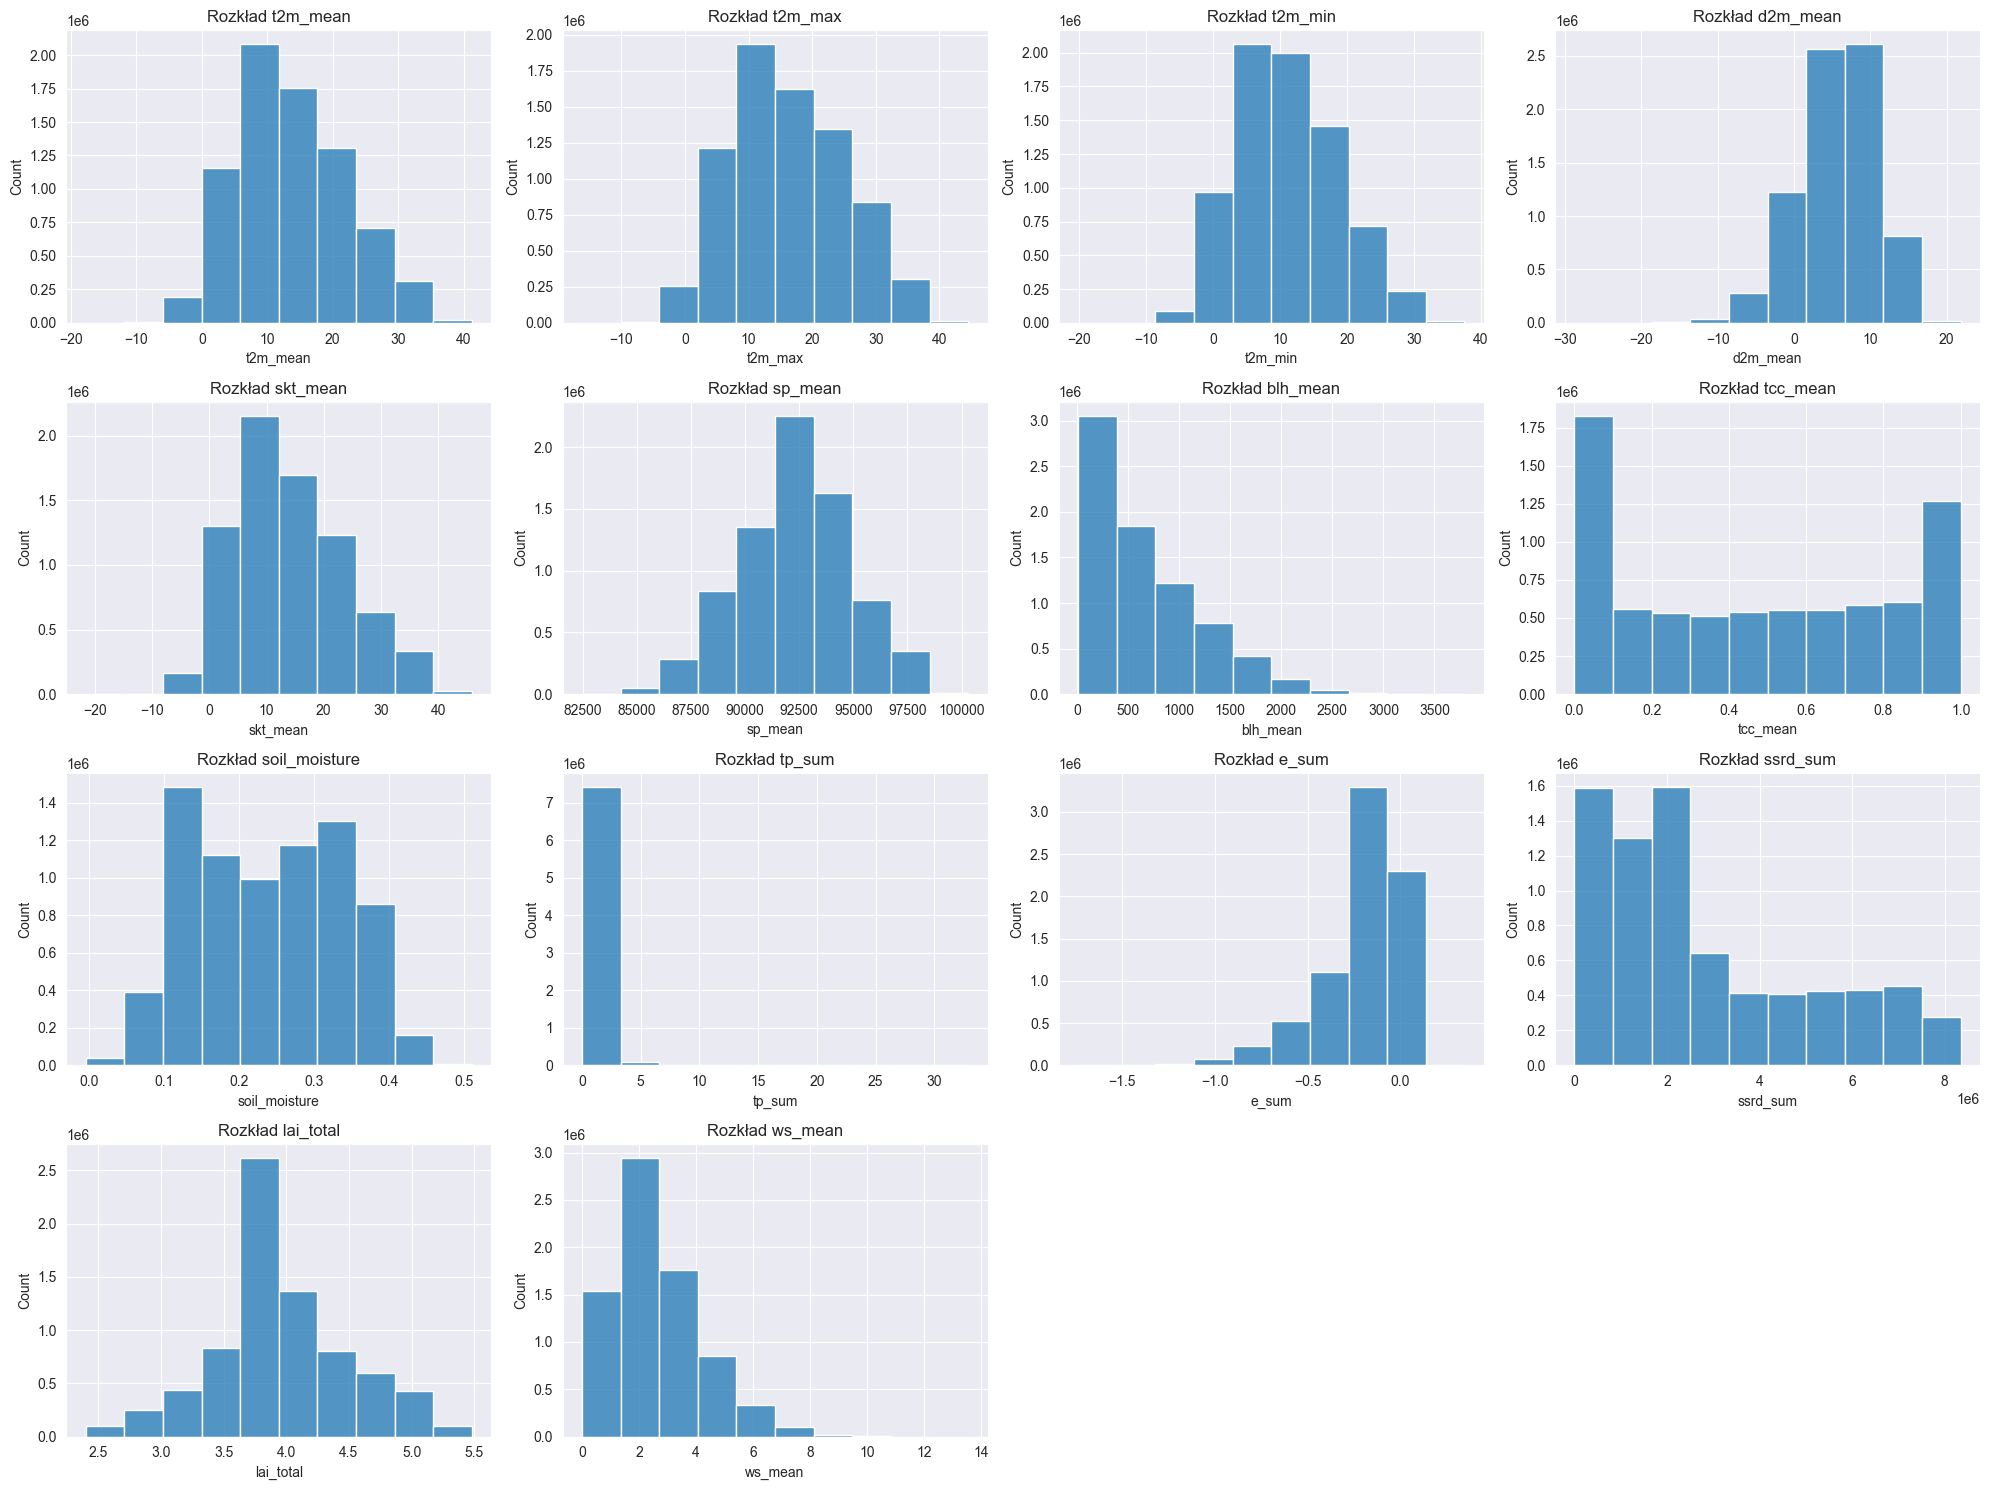

In [6]:
plt.figure( figsize = ( 20, 15 ) )
for i, col in enumerate( col_num, 1 ):
    plt.subplot( 4,4, i )
    sns.histplot( df[col] , bins = 10 )
    plt.title(f"Rozkład {col}")
plt.tight_layout()
plt.show()

### **Analiza wizualna rozkładów (Histogramy)**

Poniższa analiza opiera się na wygenerowanych histogramach i pozwala zrozumieć naturę zbieranych danych meteorologicznych/środowiskowych.

#### **1. Zmienne o rozkładzie zbliżonym do normalnego **
*   **`t2m_mean`, `t2m_max`, `t2m_min`, `skt_mean` (Temperatury):** Wykazują klasyczny kształt dzwonu, co ułatwia modelowanie statystyczne. Widoczna jest lekka asymetria prawostronna (zgodnie z wynikiem skewness), co oznacza, że ekstremalnie wysokie temperatury zdarzają się nieco rzadziej niż te umiarkowane.
*   **`sp_mean` (Ciśnienie):** Bardzo ładny, niemal idealny rozkład normalny. Dane są stabilne i skupione wokół średniej.
*   **`lai_total` (Indeks liściowy):** Rozkład zbliżony do normalnego, wycentrowany wokół wartości 4.0.

#### **2. Zmienne o silnej skośności **
*   **`tp_sum` (Opady):** Rozkład typu "L-shape". Dominacja wartości bliskich 0 (dni bez opadów) z ekstremalnie długim ogonem w prawo. To najtrudniejsza zmienna do modelowania – przy modelach ML warto rozważyć transformację logarytmiczną lub standaryzację odporną na outliery.
*   **`blh_mean` (Wysokość warstwy granicznej):** Wyraźna skośność dodatnia. Większość pomiarów to wartości niskie (poniżej 1000m), co jest typowe dla stabilnej atmosfery.
*   **`ws_mean` (Wiatr):** Rozkład asymetryczny prawostronnie (często spotykany dla wiatru – rozkład Weibulla). Większość wartości to 2-4 m/s.
*   **`e_sum` (Parowanie):** Silna skośność lewostronna. Większość wartości skupiona przy zerze, z długim ogonem w stronę wartości ujemnych.

#### **3. Rozkłady specyficzne**
*   **`tcc_mean` (Zachmurzenie):** Rozkład typu "U-shape". Widzimy dwa ogromne piki: przy **0** (niebo bezchmurne) oraz przy **1** (pełne zachmurzenie). Wartości pośrednie występują znacznie rzadziej. To typowe zachowanie dla zachmurzenia w skali globalnej/regionalnej.
*   **`soil_moisture` (Wilgotność gleby):** Rozkład wielomodalny (ma kilka "górek"). Może to sugerować występowanie różnych typów podłoża w danych lub wyraźne przejścia między stanem suszy a nasycenia gleby wodą.
*   **`ssrd_sum` (Promieniowanie słoneczne):** Rozkład "schodkowy" z dużą liczbą niskich wartości (noc/zachmurzenie) i szerokim rozrzutem dla dni słonecznych.

---



## Boxploty (Outliery / Wartości odstające)

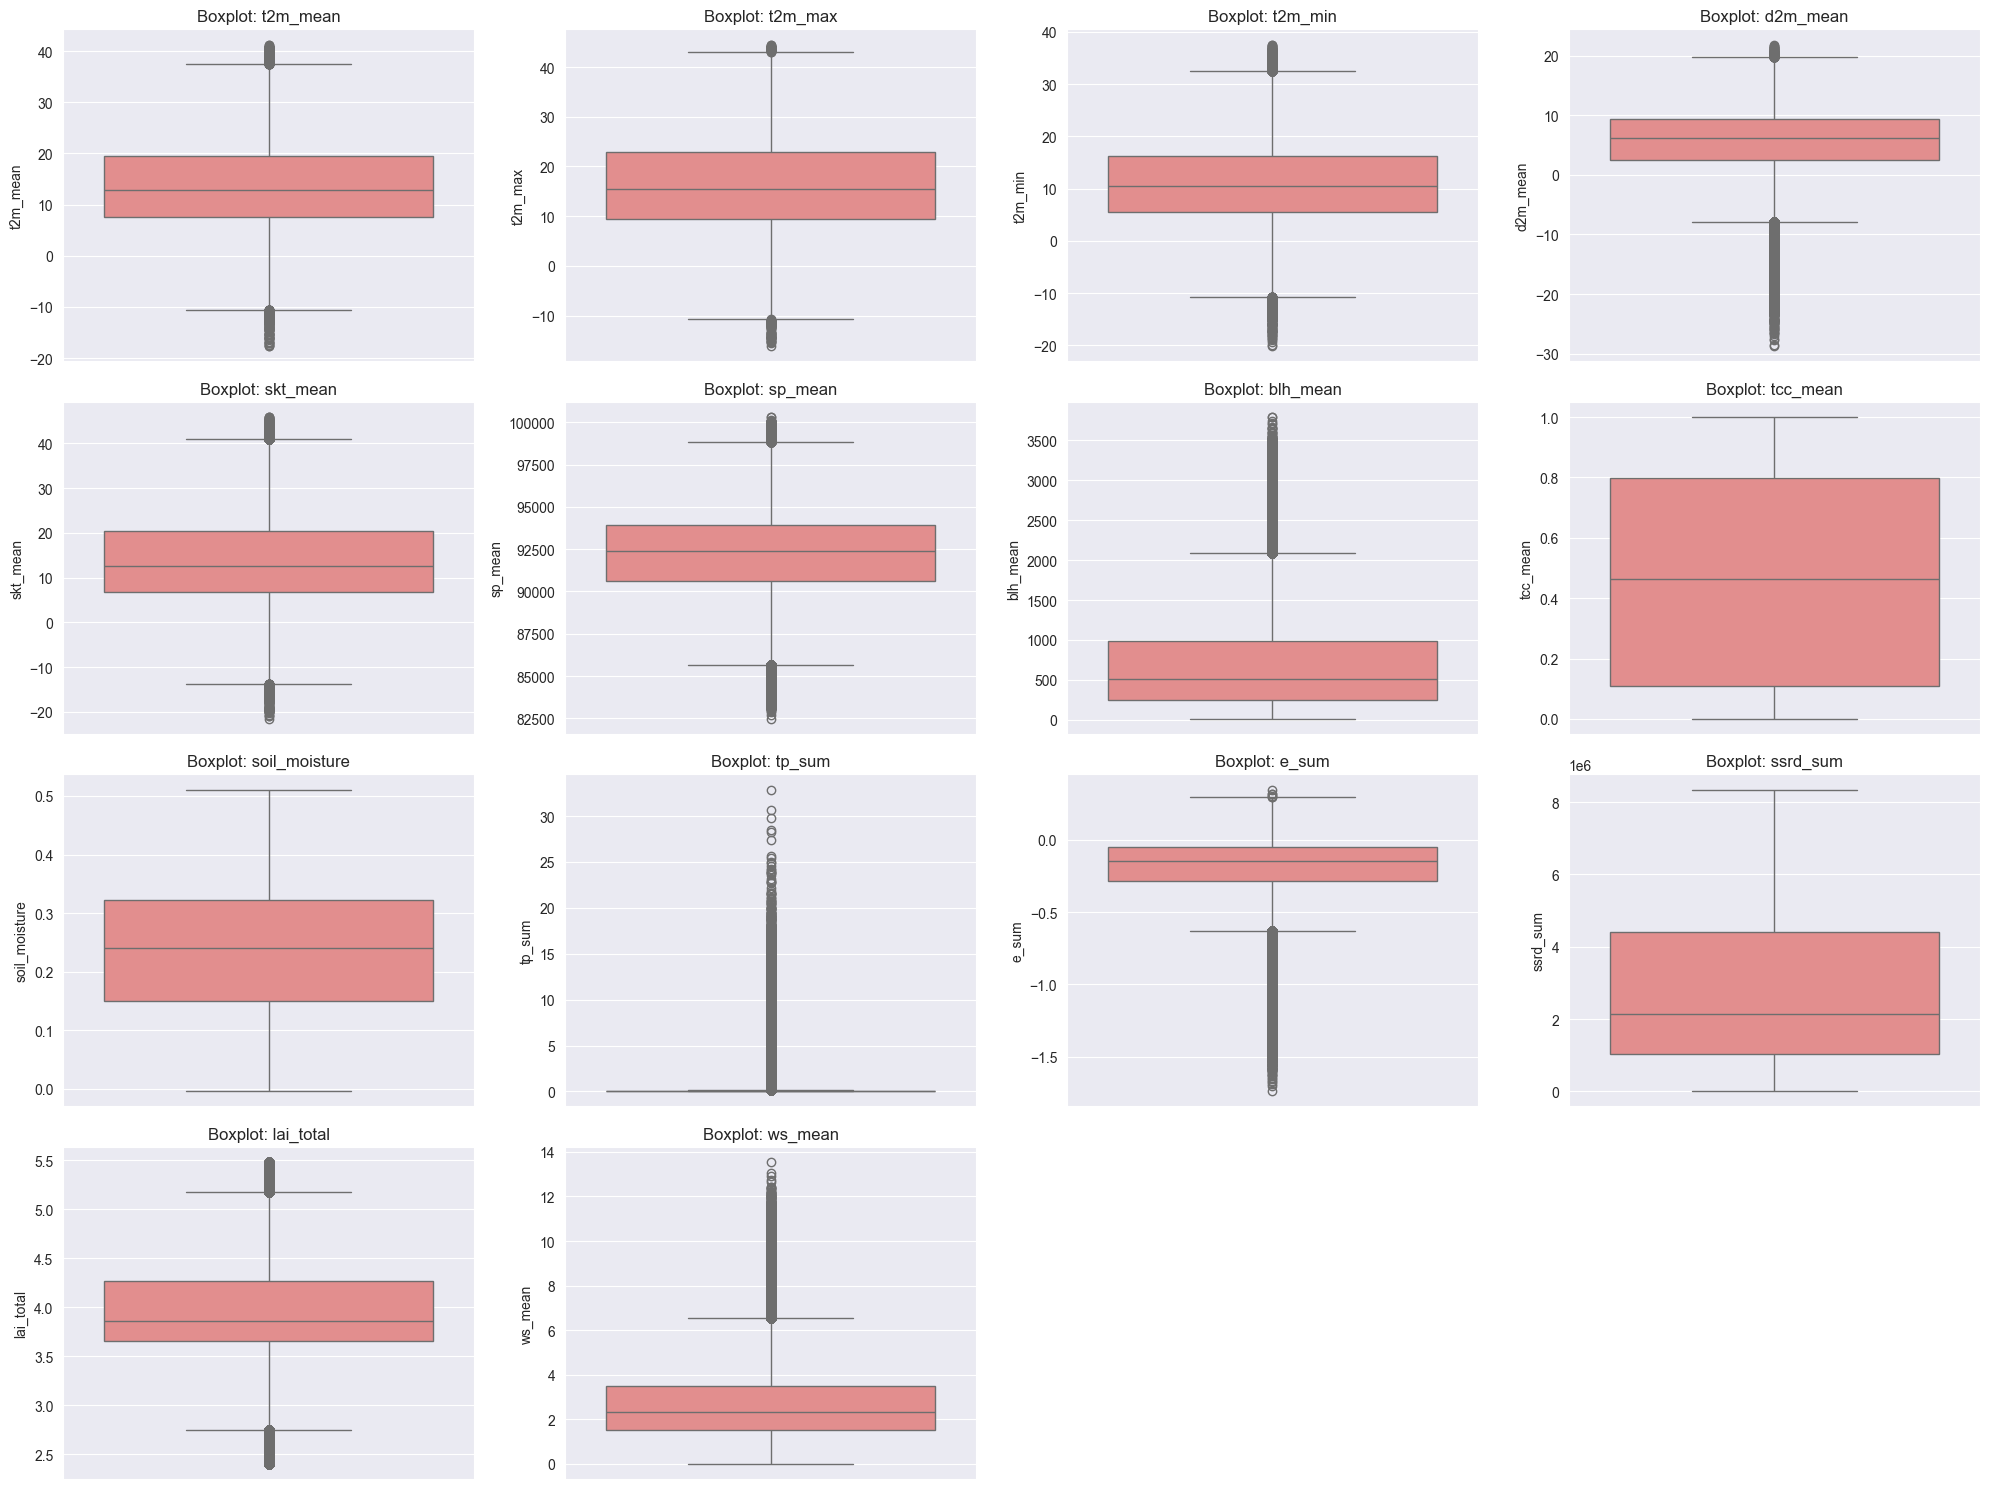

In [13]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(col_num, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[col], color='lightcoral')
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()

plt.show()

Boxploty (wykresy pudełkowe) pozwalają nam zidentyfikować wartości odstające (outliery) oraz zrozumieć, jak bardzo "ściśnięte" są nasze dane.

#### **1. Zmienne z ekstremalnymi wartościami odstającymi (Długie ogony)**
*   **`tp_sum` (Opady):** To najbardziej specyficzna zmienna. Jak wynika z `describe()`, aż **75% danych to wartości poniżej 0.08**, podczas gdy wartość maksymalna to aż **32.88**. Na wykresie pudełko jest niemal niewidoczne (płaska linia na zerze), a nad nim znajduje się bardzo gęsty "słup" punktów.
    *   *Wniosek:* Ekstremalne opady są rzadkie, ale mają ogromną skalę w porównaniu do typowego dnia.
*   **`blh_mean` (Wysokość warstwy granicznej):** Pudełko jest osadzone nisko, ale posiada bardzo długi "ogon" górny. Oznacza to, że dni z bardzo wysoką warstwą graniczną (np. silna konwekcja) są traktowane statystycznie jako wartości odstające.
*   **`ws_mean` (Wiatr):** Widoczna duża liczba outlierów powyżej górnego wąsa. Większość dni jest umiarkowanie wietrzna, ale wichury wyraźnie odcinają się od reszty zbioru.

#### **2. Zmienne o symetrycznych outlierach (Ekstrema pogodowe)**
*   **`t2m_mean`, `t2m_max`, `t2m_min`, `skt_mean` (Temperatury):** Te zmienne mają punkty odstające zarówno na górze, jak i na dole.
    *   *Górne outliery:* Fale upałów.
    *   *Dolne outliery:* Silne mrozy.
    *   Pudełka są szerokie i dobrze osadzone, co świadczy o dużej zmienności sezonowej, która jest jednak "przewidywalna" statystycznie.
*   **`sp_mean` (Ciśnienie):** Wykazuje bardzo regularny rozkład z symetrycznymi outlierami, co odpowiada rzadkim układom bardzo niskiego lub bardzo wysokiego ciśnienia.

#### **3. Zmienne stabilne (Brak lub mało outlierów)**
*   **`tcc_mean` (Zachmurzenie):** Brak kropek poza wąsami. Dane mieszczą się całkowicie w zakresie 0-1. Szerokie pudełko potwierdza to, co widzieliśmy na histogramie – dane są rozproszone (dużo zer i dużo jedynek), ale nie ma wartości "dziwnych".
*   **`soil_moisture` (Wilgotność gleby):** Bardzo czysty rozkład, brak wartości odstających. Zmienność gleby mieści się w stałych, fizycznych granicach.
*   **`ssrd_sum` (Promieniowanie):** Brak outlierów. Wartości są ograniczone od dołu przez 0 (noc) i od góry przez maksymalną możliwą stałą słoneczną dla danego regionu.

---

# Macierze współczynników korelacji liniowej Pearsona i Spearmana oraz VIF

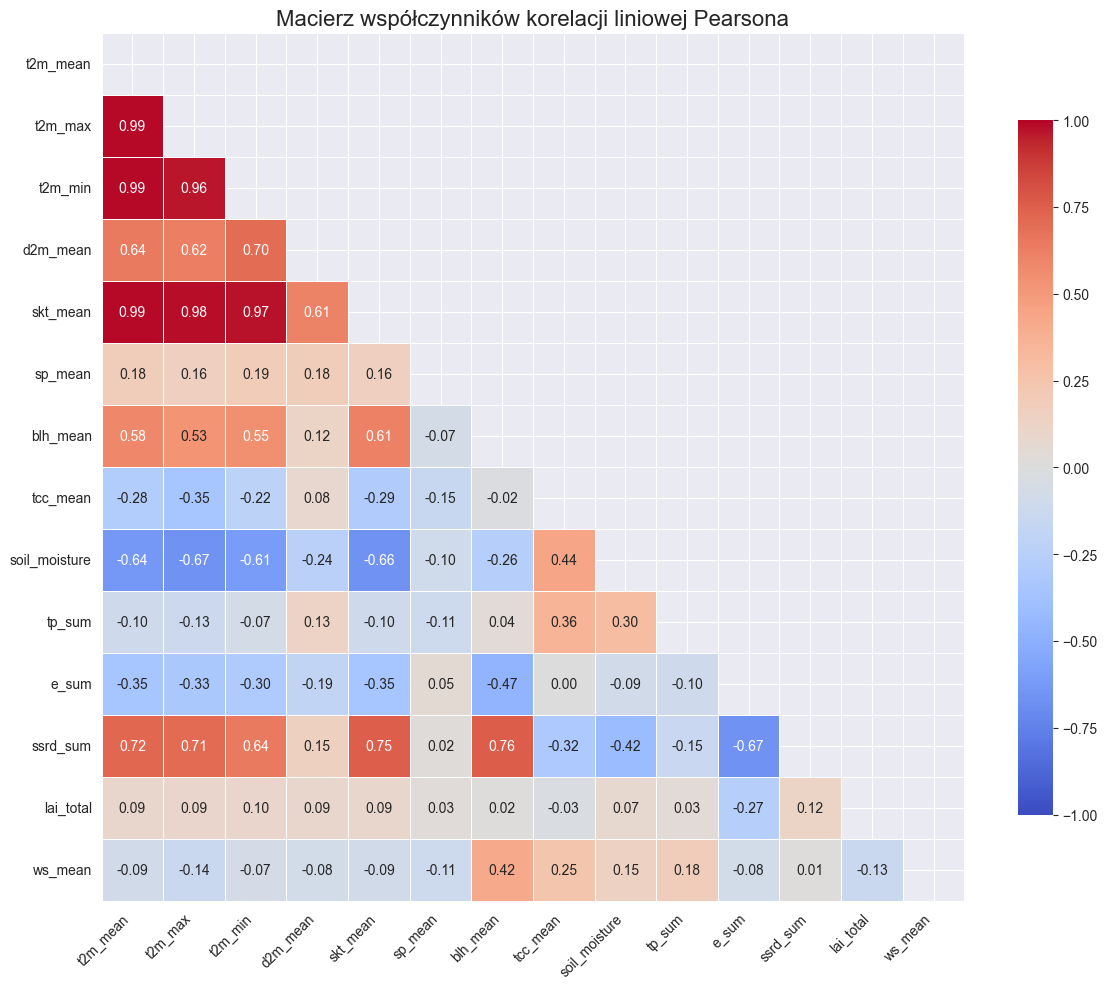

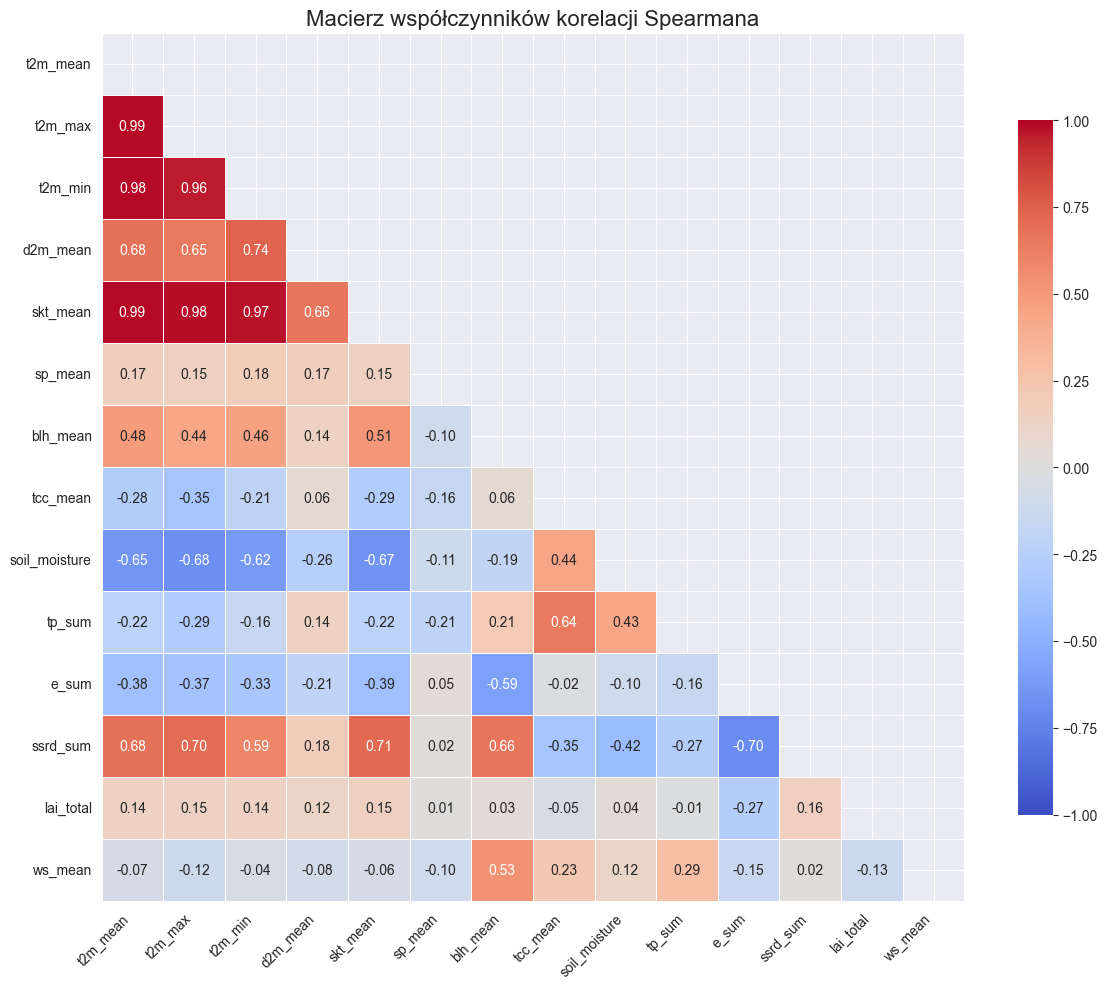

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def write_heat_map(methoda):

    corr_map = df[col_num].corr(method=methoda)
    mask = np.triu(np.ones_like(corr_map, dtype=bool))

    plt.figure(figsize=(12, 10))

    sns.heatmap(corr_map,
                mask=mask,
                annot=True,
                fmt=".2f",
                cmap="coolwarm",
                vmin=-1, vmax=1,
                center=0,
                linewidths=.5,
                cbar_kws={"shrink": .8},
                annot_kws={"size": 10})

    if methoda == "pearson":
        plt.title(f"Macierz współczynników korelacji liniowej {methoda.capitalize()}a", fontsize=16)
    elif methoda == "spearman":
        plt.title(f"Macierz współczynników korelacji {methoda.capitalize()}a", fontsize=16)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

write_heat_map("pearson")
write_heat_map("spearman")

### Analiza Macierzy Korelacji Pearsona - Wnioski

Analiza współczynników korelacji pozwala na zidentyfikowanie kluczowych zależności fizycznych w badanym zbiorze danych meteorologicznych:

#### 1. Silne sprzężenie radiacyjno-termiczne
*   **Zależność:** Wysoka dodatnia korelacja między promieniowaniem słonecznym (`ssrd_sum`) a temperaturą powietrza (`t2m_mean`, r ≈ 0.72) oraz temperaturą gruntu (`skt_mean`, r ≈ 0.75).
*   **Wniosek:** Potwierdza to, że głównym czynnikiem sterującym dobowym cyklem temperatury w tym zbiorze jest dopływ krótkofalowego promieniowania słonecznego.

#### 2. Termodynamiczne uwarunkowania warstwy granicznej
*   **Zależność:** Wysokość warstwy granicznej atmosfery (`blh_mean`) jest silnie skorelowana z promieniowaniem (`ssrd_sum`, r = 0.76) i temperaturą (r ≈ 0.58).
*   **Wniosek:** Wzrost temperatury i silne nasłonecznienie sprzyjają konwekcji termicznej, co skutkuje "puchnięciem" warstwy granicznej i wzrostem jej wysokości.

#### 3. Interakcja atmosfera-podłoże (Wilgotność gleby)
*   **Zależność:** Wyraźna ujemna korelacja między temperaturą powietrza a wilgotnością gleby (`soil_moisture`, r ≈ -0.64).
*   **Wniosek:** Mechanizm ten wskazuje na dwa zjawiska: z jednej strony wyższa temperatura zwiększa parowanie (wysuszając glebę), a z drugiej strony sucha gleba szybciej się nagrzewa (brak chłodzenia wyparnego), co dodatkowo podbija temperaturę powietrza.

#### 4. Bilans wodny i ewapotranspiracja
*   **Zależność:** Silna ujemna korelacja między parowaniem (`e_sum`) a promieniowaniem słonecznym (`ssrd_sum`, r = -0.67) oraz temperaturą.
*   **Uwaga interpretacyjna:** W danych ERA5/meteorologicznych parowanie (`e`) często ma znak ujemny (strata wody z powierzchni). Zatem korelacja ujemna w tym przypadku oznacza **zależność wprost proporcjonalną** – im wyższa temperatura i nasłonecznienie, tym silniejsze parowanie (bardziej ujemna wartość).

#### 5. Zachmurzenie a promieniowanie
*   **Zależność:** Ujemna korelacja między całkowitym zachmurzeniem (`tcc_mean`) a promieniowaniem słonecznym (`ssrd_sum`, r = -0.32) oraz temperaturą.
*   **Wniosek:** Chmury działają jako tarcza blokująca dopływ promieniowania krótkofalowego do powierzchni, co bezpośrednio hamuje wzrost temperatury w ciągu dnia.

#### 6. Zmienne słabo skorelowane (Niezależne)
*   **Ciśnienie powierzchniowe (`sp_mean`):** Wykazuje niemal zerową korelację z większością parametrów termicznych. Sugeruje to, że w badanym okresie lokalne warunki termiczne były bardziej zależne od nasłonecznienia niż od dynamicznych zmian układów barycznych (np. przejść frontów).
*   **Indeks liściowy (`lai_total`):** Bardzo niskie korelacje ze zmiennymi meteorologicznymi sugerują, że szata roślinna w tym zbiorze jest stabilna w czasie i nie reaguje gwałtownie na dobowe zmiany pogody (co jest naturalne dla procesów wegetacyjnych).

---

**Multikoliniowości**:
> *"Zmienne t2m_mean, t2m_max i t2m_min wykazują korelację bliską 1.0. W przypadku budowania modeli regresyjnych, należy rozważyć usunięcie dwóch z nich, aby uniknąć problemu multikoliniowości, który może niestabilizować wagi modelu."*


**Uwaga dot. wyboru zmiennych:**
Mimo bardzo wysokiej korelacji między `t2m_mean`, `t2m_max` oraz `t2m_min` (r > 0.98), na obecnym etapie analizy (wizualizacja i eksploracja) **wszystkie zmienne zostają zachowane**. Pozwala to na pełną charakterystykę reżimu termicznego badanego obszaru, w tym analizę ekstremów dobowych. Redukcja zmiennych (usuwanie cech współliniowych) zostanie przeprowadzona dopiero na etapie przygotowania danych do modelowania (Feature Selection), aby zapobiec problemowi multikoliniowości.


**Multikoliniowości**:
> *"Zmienne t2m_mean, t2m_max i t2m_min wykazują korelację bliską 1.0. W przypadku budowania modeli regresyjnych, należy rozważyć usunięcie dwóch z nich, aby uniknąć problemu multikoliniowości, który może niestabilizować wagi modelu."*## VIF

### **Strategia skalowania hybrydowego (Hybrid Feature Scaling)**

Po analizie skośności (Skewness) oraz wizualizacji boxplotów, zdecydowano o zastosowaniu **podejścia hybrydowego** zamiast jednego uniwersalnego skalera. Pozwala to na lepsze dopasowanie transformacji do natury fizycznej zjawisk pogodowych.

#### **1. StandardScaler dla rozkładów normalnych**
Zmienne takie jak temperatura (`t2m`), ciśnienie (`sp_mean`) oraz indeks liściowy (`lai_total`) wykazują rozkłady zbliżone do dzwonowych (skośność < 0.5).
*   **Zastosowanie:** StandardScaler centruje te dane wokół zera (średnia=0, odchylenie=1), co jest idealne dla modeli regresyjnych i neuronowych przy danych o wysokiej stabilności.

#### **2. RobustScaler dla zmiennych z ekstremalnymi wartościami odstającymi**
Zmienne o silnej skośności, takie jak opady (`tp_sum` – skew: 5.91), wiatr (`ws_mean`) oraz ewaporacja (`e_sum`), posiadają bardzo liczne wartości odstające, które reprezentują ekstremalne zjawiska pogodowe (burze, wichury).
*   **Zastosowanie:** RobustScaler wykorzystuje **medianę oraz rozstęp międzykwartylowy (IQR)** zamiast średniej i wariancji. Dzięki temu skaler nie zostaje "przesunięty" przez ekstremalne ulewy, zachowując jednocześnie informację o ich wystąpieniu w ogonie rozkładu.

#### **3. Obsługa specyficznych zmiennych brzegowych**
Zmienne takie jak zachmurzenie (`tcc_mean`) i wilgotność gleby (`soil_moisture`), mimo specyficznych kształtów (U-shape, multimodalne), mieszczą się w stałych zakresach fizycznych. Zastosowanie skalowania pozwala na ich standaryzację względem reszty cech, eliminując dominację zmiennych o dużych jednostkach (np. promieniowania czy ciśnienia).

---

### Dlaczego to jest lepsze niż jeden skaler?
*   Gdybyś użył **StandardScaler** do opadów (`tp_sum`), to przez te kilka dni z ulewą (32.8 mm), średnia byłaby tak "wyciągnięta", że 90% dni (gdzie pada mało) miałoby po skalowaniu niemal identyczną wartość (np. 0.00001). Model nie odróżniłby małego deszczu od mżawki.
*   **RobustScaler** sprawi, że małe deszcze będą miały różne wartości, a te wielkie ulewy po prostu będą miały bardzo wysokie wartości (np. 15.0 zamiast 1.0). To daje modelowi lepszą "rozdzielczość" w danych.

In [21]:
# from sklearn.preprocessing import StandardScaler, RobustScaler
# import pandas as pd
#
# # Definiujemy grupy
# cols_standard = ['t2m_mean', 't2m_max', 't2m_min', 'd2m_mean', 'skt_mean', 'sp_mean', 'lai_total']
# cols_robust = ['blh_mean', 'tp_sum', 'e_sum', 'ssrd_sum', 'ws_mean']
# cols_limited = ['tcc_mean', 'soil_moisture'] # można użyć Standard lub Robust
#
# # Tworzymy kopie/skalujemy
# std_scaler = StandardScaler()
# rob_scaler = RobustScaler()
#
# df[cols_standard] = std_scaler.fit_transform(df[cols_standard])
# df[cols_robust] = rob_scaler.fit_transform(df[cols_robust])
# df[cols_limited] = std_scaler.fit_transform(df[cols_limited]) # StandardScaler też tu zadziała ok
#
# print("Skalowanie hybrydowe zakończone.")
# df[col_num].describe()

Skalowanie hybrydowe zakończone.


,t2m_mean,t2m_max,t2m_min,d2m_mean,skt_mean,sp_mean,blh_mean,tcc_mean,soil_moisture,tp_sum,e_sum,ssrd_sum,lai_total,ws_mean
count,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06
mean,-5.389005e-08,-2.487233e-08,-6.425353e-08,-9.327125e-09,2.901772e-08,4.808651e-07,2.062576e-01,-4.663562e-08,3.109042e-08,3.127844e+00,-2.750274e-01,2.015903e-01,1.248798e-07,1.566795e-01
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.178034e-01,1.000000e+00,1.000000e+00,9.653706e+00,9.078515e-01,6.678012e-01,1.000000e+00,7.679307e-01
min,-3.789482e+00,-3.665505e+00,-4.171099e+00,-6.904233e+00,-3.739053e+00,-3.847778e+00,-6.771387e-01,-1.328396e+00,-2.492832e+00,0.000000e+00,-6.863637e+00,-6.355395e-01,-2.840341e+00,-1.162990e+00
25%,-7.538426e-01,-7.737966e-01,-7.497855e-01,-6.564176e-01,-7.652572e-01,-6.659548e-01,-3.652214e-01,-1.019276e+00,-9.180484e-01,0.000000e+00,-6.078487e-01,-3.272331e-01,-5.323244e-01,-4.097933e-01
50%,-1.157811e-01,-9.770401e-02,-9.382666e-02,7.245571e-02,-1.409653e-01,4.061643e-02,0.000000e+00,-1.218475e-02,1.429910e-02,0.000000e+00,0.000000e+00,0.000000e+00,-1.574335e-01,0.000000e+00
75%,6.936359e-01,7.444763e-01,6.946189e-01,7.268949e-01,6.729928e-01,6.249197e-01,6.347786e-01,9.388118e-01,8.542316e-01,1.000000e+00,3.921513e-01,6.727669e-01,5.839428e-01,5.902067e-01
max,3.313262e+00,3.187780e+00,3.526164e+00,3.223789e+00,3.346526e+00,3.129073e+00,4.430779e+00,1.511507e+00,2.788023e+00,4.033275e+02,2.113880e+00,1.837701e+00,2.817150e+00,5.589063e+00
